In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import io
import os
import tradingWithPython as twp
from tradingWithPython import sharpe # general trading toolbox functions
import tradingWithPython.lib.yahooFinance as yf
from tradingWithPython import cboe_ckc as ckc
import pandas as pd # pandas time series library
from datetime import datetime
import quandl
quandl.ApiConfig.api_key = 'wxychbrgu7o7x3MRq4Hx'

C:\Users\chekitsch\Anaconda3\lib\site-packages\tradingWithPython\lib\cboe.py:11: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## HSI bottom - UBC(80)

In [3]:
hist = yf.getHistoricData('^HSI')
hist['high_80d'] = hist.high.rolling(window=80).max()

Got 7522 days of data


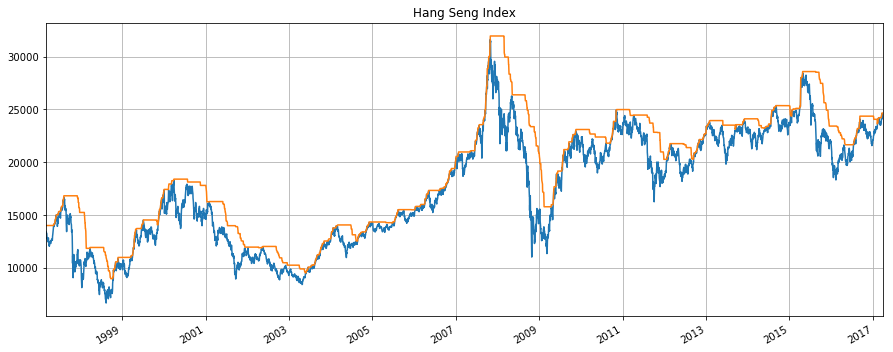

In [6]:
figsize(15,6)
hist.close.tail(5000).plot(grid=True)
hist.high_80d.tail(5000).plot(grid=True)
title('Hang Seng Index')

## Retrieve HK lists

In [8]:
url = 'https://www.hkex.com.hk/eng/market/sec_tradinfo/stockcode/eisdeqty.htm'
mainboard = pd.read_html(url, attrs={'class': 'table_grey_border'}, header=0)[0]

url = 'https://www.hkex.com.hk/eng/market/sec_tradinfo/stockcode/eisdhdr.htm'
hdr = pd.read_html(url, attrs={'class': 'table_grey_border'}, header=0)[0]

url = 'https://www.hkex.com.hk/eng/market/sec_tradinfo/stockcode/eisdreit.htm'
reit = pd.read_html(url, attrs={'class': 'table_grey_border'}, header=0)[0]

url = 'https://www.hkex.com.hk/eng/market/sec_tradinfo/stockcode/eisdgems.htm'
gem = pd.read_html(url, attrs={'class': 'table_grey_border'}, header=0)[0]

symbols = pd.concat( [mainboard['STOCK CODE'], hdr['STOCK CODE'], reit['STOCK CODE'], gem['STOCK  CODE']] )

In [9]:
'''convert symbols to string, add trailing zeros'''
symbols = symbols.reset_index().ix[:,1]
symbols = symbols.apply(str)

for i, sym in enumerate(symbols):
    symbols[i] = sym.zfill(4) + '.HK'
    
symbols = symbols[symbols.apply(len)<8]   # keep 4-digit tickers only
len(symbols)

2009

** Download Yahoo stock data **

In [10]:
hkstocks = yf.HistData()
hkstocks.startDate = (2014,1,1) # start from 2009
hkstocks.downloadData(symbols.tolist())

Failed to download:
<urlopen error [Errno 11004] getaddrinfo failed>
'NoneType' object is not subscriptable
 [****************      34%                       ]  676 of 2009 completeFailed to download:
HTTP Error 404: Not Found
'NoneType' object is not subscriptable
 [**********************52%                       ]  1040 of 2009 completeFailed to download:
HTTP Error 404: Not Found
'NoneType' object is not subscriptable
 [**********************53%                       ]  1055 of 2009 completeFailed to download:
HTTP Error 404: Not Found
'NoneType' object is not subscriptable
 [**********************53%                       ]  1061 of 2009 completeFailed to download:
HTTP Error 404: Not Found
'NoneType' object is not subscriptable
 [**********************55%*                      ]  1108 of 2009 completeFailed to download:
HTTP Error 404: Not Found
'NoneType' object is not subscriptable
 [**********************59%***                    ]  1191 of 2009 completeFailed to download:
HTTP

In [11]:
hkstocks.downloadData([symbols[676],symbols[1401],symbols[1426],symbols[1427]])

Failed to download:
<urlopen error [Errno 11004] getaddrinfo failed>
'NoneType' object is not subscriptable
 [*********************100%***********************]  4 of 4 complete

In [20]:
hkstocks.getDataFrame('close').tail(1).count(axis=1)

2017-03-31    1848
dtype: int64

**GET QUOTES from Yahoo**

In [12]:
a = yf.getQuote(symbols.tolist()[:1000])
b = yf.getQuote(symbols.tolist()[1000:])

In [13]:
c = a.append(b)

In [14]:
ma250 = hkstocks.getDataFrame('close').iloc[-250:,:].mean()
c['ma250'] = ma250
volume_prevday = hkstocks.getDataFrame('volume').iloc[-1:,:].mean()
c['volume_prev'] = volume_prevday
c['change_pct'] = 100*((c['last'] / c['prev_close']) - 1)
c['last'] = c['last'].astype(float)

In [32]:
c[(c.Low>=c.Open-0.01) & (c['last']<c.ma250) & (c.change_pct>1.5) & (c.volume>2*c.adv)].sort_values('change_pct', ascending=False)
#c[(c.volume>7*c.adv) & (c.change_pct>1)].sort_values('change_pct', ascending=False)
#c[(c.volume>5*c.adv) & (c['last']>c.ma250)].sort_values('change_pct', ascending=False)
#c[(c.volume>1*c.adv) & (c.volume<5*c.adv) & (c['last']>c.ma250)].sort_values('change_pct', ascending=False)

,High,Low,Open,adv,last,market_cap,prev_close,time,volume,ma250,volume_prev,change_pct
0299.HK,0.089,0.073,0.074,37448400.0,0.086,2.930000e+09,0.072,11:57am,127270000.0,0.122744,23100000.0,19.444444
1349.HK,6.550,6.210,6.210,342045.0,6.550,2.230000e+09,6.130,11:56am,2491000.0,6.790385,NaN,6.851550
0648.HK,0.042,0.038,0.038,26015900.0,0.041,2.673600e+08,0.039,11:57am,244027200.0,0.076020,12721000.0,5.128205
2700.HK,0.228,0.206,0.209,1300510.0,0.227,4.476400e+08,0.216,11:52am,3920000.0,0.227848,260000.0,5.092593
8045.HK,0.325,0.310,0.310,212615.0,0.325,1.368300e+08,0.315,10:59am,666000.0,0.375520,186000.0,3.174603
0275.HK,0.255,0.240,0.245,27346100.0,0.246,2.530000e+09,0.242,11:56am,134602950.0,0.318172,76100600.0,1.652893


In [14]:
c[(c.volume > 1.0*c.volume_prev) & (c.volume_prev>1000000)].sort_values('change_pct', ascending=False)

,High,Low,Open,adv,last,market_cap,prev_close,time,volume,ma250,volume_prev,change_pct
1088.HK,19.780,18.900,19.000,18337800.0,19.000,6.458000e+10,16.460,10:11am,72561299.0,14.693204,30733900.0,15.431349
0799.HK,8.550,7.750,7.750,10229200.0,8.440,1.133000e+10,7.650,10:11am,32636752.0,4.721640,24877200.0,10.326797
1458.HK,9.440,8.510,8.510,2525060.0,9.200,2.192000e+10,8.440,10:11am,8877641.0,6.938022,8567800.0,9.004739
1194.HK,0.216,0.202,0.202,19585700.0,0.209,2.900000e+09,0.194,10:11am,62258000.0,0.239244,52768000.0,7.731959
0276.HK,0.310,0.290,0.290,4979700.0,0.300,5.643000e+08,0.280,10:05am,7643500.0,0.254964,2228900.0,7.142857
0281.HK,0.650,0.590,0.640,988104.0,0.630,1.640000e+09,0.590,10:01am,5866000.0,0.486384,1572000.0,6.779661
0129.HK,1.900,1.830,1.850,1036380.0,1.880,2.480000e+09,1.780,10:10am,4855808.0,1.528852,2231600.0,5.617978
0777.HK,24.250,23.100,23.200,507935.0,24.250,1.200000e+10,23.100,10:11am,1488000.0,24.161360,1005100.0,4.978355
1733.HK,1.540,1.460,1.460,22051300.0,1.510,4.670000e+09,1.450,10:11am,10878630.0,190.064001,7917200.0,4.137931
1898.HK,4.320,4.170,4.230,10586800.0,4.180,1.717000e+10,4.020,10:11am,20996100.0,3.900680,19874700.0,3.980100
